In [33]:
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

sys.path.append(parent_dir)

from simtrain import SETTINGS_POLIMI as SETTINGS
from simtrain.sim_models_new import Toy_intensity_Generator
import torch
import paths
from os.path import join

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



In [34]:

state_size = SETTINGS.STATE_SIZE
experiment_name = "toy"
#num_negatives = 100
#conditioned=True
#kl_weight=.01

In [35]:
# parameter dicts
width= 8
user_state_dict = {"model_hyp": {"layer_width": [width, width]}}
intensity_state_dict = {"model_hyp": {"layer_width": [width, width],
                                                         "noise": 0}
                            }


hyperparameter_dict = {"state_size": state_size, "state_model": user_state_dict, 
                           "intensity_model": intensity_state_dict,# "num_recom" : num_items_per_recom,
                            "noise": 0.}
gen_model = Toy_intensity_Generator(hyperparameter_dict)

In [36]:
path = join(paths.dat, SETTINGS.filepaths_new["simulate_intensity_model"]
            )
path

'/home/thahit/github/Recommender_Sim/dat/saved_models_polimi/simulate_intensity/gnerator_model.h5'

In [37]:
#torch.save(gen_model.state_dict(), path)
gen_model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [38]:
state = torch.zeros((1, state_size))

In [39]:
samples = [gen_model.sample_one(state).detach().numpy() for _ in range(100)]
samples = np.array(samples)
samples

array([[0.34933025],
       [0.9741331 ],
       [0.30820295],
       [0.658048  ],
       [2.230833  ],
       [1.3252295 ],
       [0.15062225],
       [1.974431  ],
       [0.575677  ],
       [0.19856933],
       [0.6511824 ],
       [0.658048  ],
       [1.5666155 ],
       [0.658048  ],
       [0.10953321],
       [1.5942267 ],
       [0.10953321],
       [0.80915266],
       [0.02053335],
       [1.4769138 ],
       [0.14377354],
       [0.23282377],
       [0.40417922],
       [2.3905013 ],
       [3.7130938 ],
       [0.3561856 ],
       [0.62372255],
       [1.2701072 ],
       [3.5087073 ],
       [1.9467437 ],
       [0.30820295],
       [0.8228954 ],
       [0.9191231 ],
       [2.4182932 ],
       [0.05475981],
       [0.7473227 ],
       [0.02737822],
       [0.13692504],
       [1.0085229 ],
       [0.8778765 ],
       [0.912248  ],
       [2.3974485 ],
       [0.8022817 ],
       [3.1646821 ],
       [0.5550896 ],
       [1.649465  ],
       [0.02053335],
       [0.253

feed in true values for fake models, 


/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  if sys.path[0] == "":


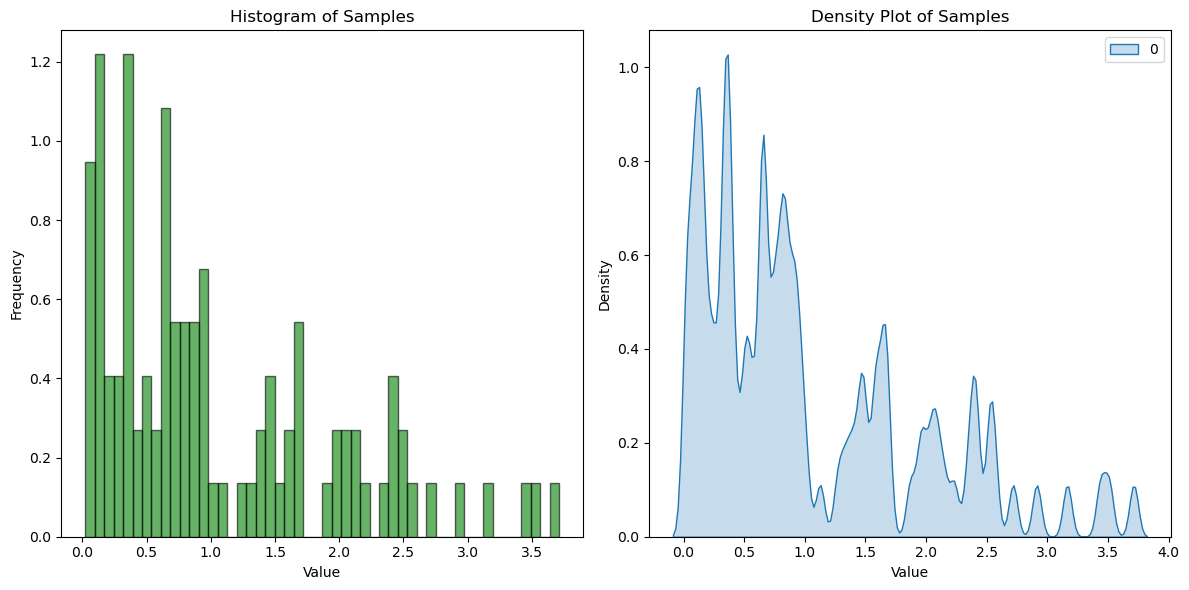

In [40]:
plt.figure(figsize=(12, 6))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(samples, bins=50, density=True, alpha=0.6, color='g', edgecolor='black')
plt.title('Histogram of Samples')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Density Plot
plt.subplot(1, 2, 2)
sns.kdeplot(samples, shade=True, color='g', bw_adjust=0.1)
plt.title('Density Plot of Samples')
plt.xlabel('Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()


In [41]:
sample_path = gen_model.sample_path(num_samples=14)

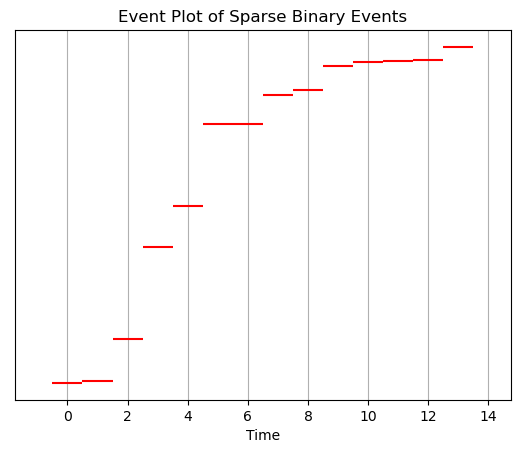

In [42]:
plt.eventplot(sample_path, orientation='vertical', colors='r')
plt.yticks([])
plt.xlabel('Time')
plt.title('Event Plot of Sparse Binary Events')
plt.grid(True)
plt.show()


In [43]:
from tqdm import tqdm
def train(model, path, scoring_func,optimizer, num_epochs=100, num_tries=20):
    
    for iter in tqdm(range(num_epochs)):
        last_t = 0
        state = torch.zeros((1, state_size))
        loss = 0.
        for timestep in path:
            current_pred = []
            for _ in range(num_tries):
                current_pred.append(last_t + model.sample_one(state))
            current_pred = torch.stack(current_pred)
            loss += scoring_func(current_pred, timestep)
            delta = timestep-last_t
            last_t = timestep
            state = model.evolve_state(state, delta)
        print(loss)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        #loss calculation

In [44]:
def energy_score_loss(forecast_samples, observed_value):
    """
    Compute the energy score loss for a set of forecast samples and an observed value.
    
    Args:
        forecast_samples (torch.Tensor): Samples drawn from the forecast distribution (shape: [N, D]).
        observed_value (torch.Tensor): The observed outcome (shape: [D]).
        
    Returns:
        torch.Tensor: The energy score loss.
    """
    N = forecast_samples.size(0)
    #print(observed_value)

    # Compute distances between the observed value and forecast samples
    distances_to_observed = torch.norm(forecast_samples - observed_value, dim=1)
    
    # Compute pairwise distances between forecast samples
    pairwise_distances = torch.cdist(forecast_samples, forecast_samples, p=2)
    
    term1 = distances_to_observed.mean()
    term2 = pairwise_distances.mean() / 2
    
    energy_score = term1 - term2
    return energy_score

In [45]:
# parameter dicts
width= 8
user_state_dict = {"model_hyp": {"layer_width": [width, width]}}
intensity_state_dict = {"model_hyp": {"layer_width": [width, width],
                                                         "noise": 0}
                            }


hyperparameter_dict = {"state_size": state_size, "state_model": user_state_dict, 
                           "intensity_model": intensity_state_dict,# "num_recom" : num_items_per_recom,
                            "noise": 0.}
train_model = Toy_intensity_Generator(hyperparameter_dict)

In [46]:
path = join(paths.dat, SETTINGS.filepaths_new["copy_intensity_model"]
            )
#torch.save(gen_model.state_dict(), path)
gen_model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [47]:
import torch.optim as optim
sample_path = torch.as_tensor(sample_path)
optimizer = optim.AdamW(gen_model.parameters(), lr=0.01,
                        weight_decay=1e-7)


In [48]:
train(gen_model, sample_path, scoring_func=energy_score_loss,optimizer=optimizer, num_epochs=10, num_tries=20)

  0%|          | 0/10 [00:02<?, ?it/s]

tensor(10.0058)


AttributeError: 'Tensor' object has no attribute 'backwards'